# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [22]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

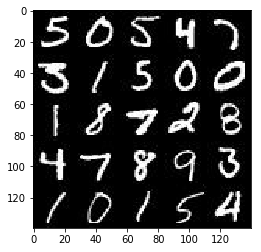

In [23]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

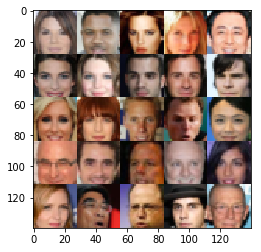

In [24]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [26]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [27]:
def leakyReLU(x, alpha=0.2):
    return tf.maximum(alpha * x, x)


def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s) //dataset will be in the range of -0.5 to 0.5 of 28x28
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Improvements: use odd-sized filters. Kernel size of 5 is a better choice nstead of 4.
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        c1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='same')
        relu1 = leakyReLU(c1, alpha)
    
        #print(relu1.shape)
        # now 14x14x64
        
        c2 = tf.layers.conv2d(relu1, filters=128, kernel_size=(5,5), strides=(2,2), padding='same')
        bn2 = tf.layers.batch_normalization(c2, training=True)
        relu2 = leakyReLU(bn2, alpha)
        
        #print(relu2.shape)
        # now 7x7x128
        
        c3 = tf.layers.conv2d(relu2, filters=256, kernel_size=(5,5), strides=(2,2), padding='same')
        bn3 = tf.layers.batch_normalization(c3, training=True)
        relu3 = leakyReLU(bn3, alpha)
        
        #print(relu3.shape)
        # now 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [28]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope('generator', reuse=not is_train):
        # project input vector with fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = leakyReLU(bn1)
        #print(relu1.shape)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 4, strides=1, padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = leakyReLU(bn2)
        #print(relu2.shape)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = leakyReLU(bn3)
        #print(relu3.shape)
        # 14x14x256 now
    
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.shape)
        # 28x28xoutput_dim now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # smothing labels
    smooth = 0.0
    
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    g_out_fake = generator(input_z, out_channel_dim, is_train=True)
    d_out_fake, d_logits_fake = discriminator(g_out_fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_out_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_out_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_out_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

    return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
   
    
    #? tf.reset_default_graph()
    print(data_shape)
    _, image_width, image_height, image_channels = data_shape
    
    # get placeholders
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # get losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # get optimizers    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # Train Model
    print_every = 25
    show_every = 200
    saver = tf.train.Saver()
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Scale images: 
                #   The output from the generator is bound between -1 and 1 as tanh activation function is used in the output layer. 
                #   The input batch images are in the range -0.5 to 0.5. They must be scaled to match the values as in generated image. 
                batch_images = batch_images * 2
                
                # TODO: Train Model
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr:learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z, 
                                               lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                                input_z: batch_z, 
                                                lr:learning_rate})
                    
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                                input_z: batch_z, 
                                                lr:learning_rate})

                    print("Epoch: {}/{};".format(epoch_i+1, epochs),
                          "Batch: {:5d};".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

                    
        saver.save(sess, './generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch: 1/2; Batch:    25; Discriminator Loss: 1.2709... Generator Loss: 0.9351
Epoch: 1/2; Batch:    50; Discriminator Loss: 0.9059... Generator Loss: 0.8057
Epoch: 1/2; Batch:    75; Discriminator Loss: 0.5317... Generator Loss: 1.9243
Epoch: 1/2; Batch:   100; Discriminator Loss: 0.9717... Generator Loss: 0.7519
Epoch: 1/2; Batch:   125; Discriminator Loss: 0.6888... Generator Loss: 1.1196
Epoch: 1/2; Batch:   150; Discriminator Loss: 0.8866... Generator Loss: 2.4960
Epoch: 1/2; Batch:   175; Discriminator Loss: 1.0031... Generator Loss: 0.6606
Epoch: 1/2; Batch:   200; Discriminator Loss: 0.8215... Generator Loss: 1.6652


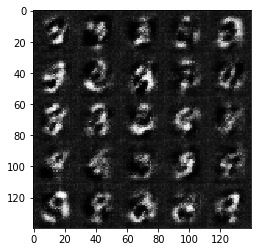

Epoch: 1/2; Batch:   225; Discriminator Loss: 0.8942... Generator Loss: 0.8261
Epoch: 1/2; Batch:   250; Discriminator Loss: 0.9428... Generator Loss: 1.9983
Epoch: 1/2; Batch:   275; Discriminator Loss: 1.1443... Generator Loss: 0.4761
Epoch: 1/2; Batch:   300; Discriminator Loss: 0.7573... Generator Loss: 1.7639
Epoch: 1/2; Batch:   325; Discriminator Loss: 0.8162... Generator Loss: 0.8290
Epoch: 1/2; Batch:   350; Discriminator Loss: 0.6350... Generator Loss: 1.1360
Epoch: 1/2; Batch:   375; Discriminator Loss: 0.6624... Generator Loss: 1.5433
Epoch: 1/2; Batch:   400; Discriminator Loss: 0.6485... Generator Loss: 1.1520


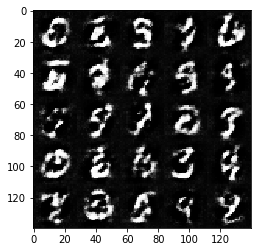

Epoch: 1/2; Batch:   425; Discriminator Loss: 0.8574... Generator Loss: 2.3549
Epoch: 1/2; Batch:   450; Discriminator Loss: 0.7430... Generator Loss: 0.8331
Epoch: 1/2; Batch:   475; Discriminator Loss: 0.8311... Generator Loss: 2.2920
Epoch: 1/2; Batch:   500; Discriminator Loss: 1.3207... Generator Loss: 0.3739
Epoch: 1/2; Batch:   525; Discriminator Loss: 0.8670... Generator Loss: 2.3925
Epoch: 1/2; Batch:   550; Discriminator Loss: 0.5332... Generator Loss: 1.8902
Epoch: 1/2; Batch:   575; Discriminator Loss: 0.9707... Generator Loss: 2.3688
Epoch: 1/2; Batch:   600; Discriminator Loss: 0.6970... Generator Loss: 1.3423


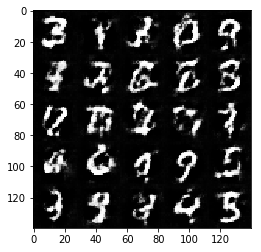

Epoch: 1/2; Batch:   625; Discriminator Loss: 1.0032... Generator Loss: 2.0788
Epoch: 1/2; Batch:   650; Discriminator Loss: 1.0562... Generator Loss: 0.5968
Epoch: 1/2; Batch:   675; Discriminator Loss: 0.7478... Generator Loss: 0.9962
Epoch: 1/2; Batch:   700; Discriminator Loss: 0.5877... Generator Loss: 1.2952
Epoch: 1/2; Batch:   725; Discriminator Loss: 0.7353... Generator Loss: 0.9809
Epoch: 1/2; Batch:   750; Discriminator Loss: 0.7678... Generator Loss: 0.9566
Epoch: 1/2; Batch:   775; Discriminator Loss: 0.6984... Generator Loss: 2.1048
Epoch: 1/2; Batch:   800; Discriminator Loss: 0.8262... Generator Loss: 1.1303


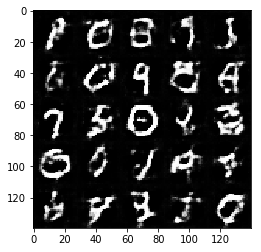

Epoch: 1/2; Batch:   825; Discriminator Loss: 0.6851... Generator Loss: 1.0243
Epoch: 1/2; Batch:   850; Discriminator Loss: 0.9619... Generator Loss: 0.6668
Epoch: 1/2; Batch:   875; Discriminator Loss: 0.8589... Generator Loss: 0.7894
Epoch: 1/2; Batch:   900; Discriminator Loss: 0.8120... Generator Loss: 0.8207
Epoch: 1/2; Batch:   925; Discriminator Loss: 0.8841... Generator Loss: 1.8420
Epoch: 2/2; Batch:   950; Discriminator Loss: 0.7602... Generator Loss: 1.0371
Epoch: 2/2; Batch:   975; Discriminator Loss: 1.3273... Generator Loss: 0.4013
Epoch: 2/2; Batch:  1000; Discriminator Loss: 1.2104... Generator Loss: 0.4523


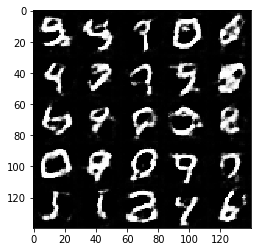

Epoch: 2/2; Batch:  1025; Discriminator Loss: 0.8952... Generator Loss: 1.8407
Epoch: 2/2; Batch:  1050; Discriminator Loss: 0.8340... Generator Loss: 0.8837
Epoch: 2/2; Batch:  1075; Discriminator Loss: 0.7278... Generator Loss: 1.4237
Epoch: 2/2; Batch:  1100; Discriminator Loss: 0.8305... Generator Loss: 1.6647
Epoch: 2/2; Batch:  1125; Discriminator Loss: 0.7926... Generator Loss: 1.5158
Epoch: 2/2; Batch:  1150; Discriminator Loss: 0.8950... Generator Loss: 0.7395
Epoch: 2/2; Batch:  1175; Discriminator Loss: 0.7736... Generator Loss: 1.1898
Epoch: 2/2; Batch:  1200; Discriminator Loss: 0.7102... Generator Loss: 1.0811


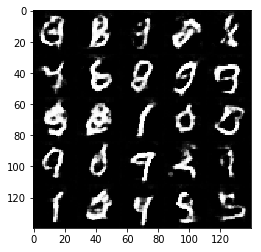

Epoch: 2/2; Batch:  1225; Discriminator Loss: 1.0915... Generator Loss: 0.5589
Epoch: 2/2; Batch:  1250; Discriminator Loss: 1.0564... Generator Loss: 2.0405
Epoch: 2/2; Batch:  1275; Discriminator Loss: 0.6203... Generator Loss: 1.2142
Epoch: 2/2; Batch:  1300; Discriminator Loss: 1.0292... Generator Loss: 0.5961
Epoch: 2/2; Batch:  1325; Discriminator Loss: 0.8134... Generator Loss: 0.8280
Epoch: 2/2; Batch:  1350; Discriminator Loss: 0.6661... Generator Loss: 1.2524
Epoch: 2/2; Batch:  1375; Discriminator Loss: 0.7477... Generator Loss: 1.0283
Epoch: 2/2; Batch:  1400; Discriminator Loss: 0.6410... Generator Loss: 1.0949


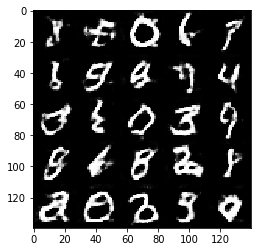

Epoch: 2/2; Batch:  1425; Discriminator Loss: 0.7263... Generator Loss: 1.0687
Epoch: 2/2; Batch:  1450; Discriminator Loss: 0.6909... Generator Loss: 1.2199
Epoch: 2/2; Batch:  1475; Discriminator Loss: 0.7805... Generator Loss: 0.9386
Epoch: 2/2; Batch:  1500; Discriminator Loss: 0.8466... Generator Loss: 0.8606
Epoch: 2/2; Batch:  1525; Discriminator Loss: 1.1925... Generator Loss: 3.1700
Epoch: 2/2; Batch:  1550; Discriminator Loss: 0.6195... Generator Loss: 1.2915
Epoch: 2/2; Batch:  1575; Discriminator Loss: 0.6179... Generator Loss: 1.5414
Epoch: 2/2; Batch:  1600; Discriminator Loss: 0.8300... Generator Loss: 0.8305


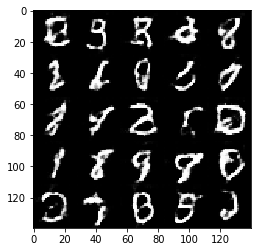

Epoch: 2/2; Batch:  1625; Discriminator Loss: 1.0260... Generator Loss: 0.5517
Epoch: 2/2; Batch:  1650; Discriminator Loss: 0.8641... Generator Loss: 0.8998
Epoch: 2/2; Batch:  1675; Discriminator Loss: 0.8284... Generator Loss: 0.7915
Epoch: 2/2; Batch:  1700; Discriminator Loss: 0.4692... Generator Loss: 1.7475
Epoch: 2/2; Batch:  1725; Discriminator Loss: 0.9443... Generator Loss: 0.6340
Epoch: 2/2; Batch:  1750; Discriminator Loss: 0.5680... Generator Loss: 1.4358
Epoch: 2/2; Batch:  1775; Discriminator Loss: 0.8141... Generator Loss: 0.7872
Epoch: 2/2; Batch:  1800; Discriminator Loss: 0.5688... Generator Loss: 1.3372


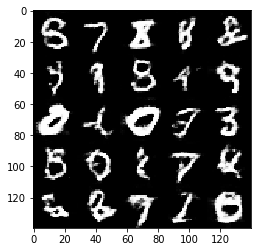

Epoch: 2/2; Batch:  1825; Discriminator Loss: 0.5619... Generator Loss: 1.5556
Epoch: 2/2; Batch:  1850; Discriminator Loss: 0.6703... Generator Loss: 1.0411


In [33]:
batch_size = 32
z_dim = 200
learning_rate = 0.001
beta1 = 0.2
# ==> Generator Loss gets bigger over, imgages gets bader

batch_size = 32
z_dim = 200
learning_rate = 0.0001
beta1 = 0.2

batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch: 1/1; Batch:    25; Discriminator Loss: 0.8692... Generator Loss: 0.9610
Epoch: 1/1; Batch:    50; Discriminator Loss: 0.5495... Generator Loss: 1.2372
Epoch: 1/1; Batch:    75; Discriminator Loss: 0.8760... Generator Loss: 5.6633
Epoch: 1/1; Batch:   100; Discriminator Loss: 0.4566... Generator Loss: 4.2164
Epoch: 1/1; Batch:   125; Discriminator Loss: 0.1372... Generator Loss: 3.3455
Epoch: 1/1; Batch:   150; Discriminator Loss: 0.5852... Generator Loss: 1.1342
Epoch: 1/1; Batch:   175; Discriminator Loss: 0.1847... Generator Loss: 2.9129
Epoch: 1/1; Batch:   200; Discriminator Loss: 0.2694... Generator Loss: 2.2431


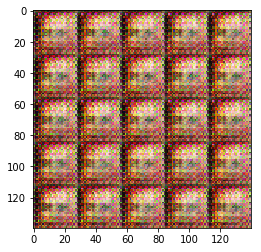

Epoch: 1/1; Batch:   225; Discriminator Loss: 0.1262... Generator Loss: 2.8657
Epoch: 1/1; Batch:   250; Discriminator Loss: 0.0977... Generator Loss: 3.0453
Epoch: 1/1; Batch:   275; Discriminator Loss: 0.1459... Generator Loss: 2.6890
Epoch: 1/1; Batch:   300; Discriminator Loss: 0.4600... Generator Loss: 2.0034
Epoch: 1/1; Batch:   325; Discriminator Loss: 0.3846... Generator Loss: 2.7158
Epoch: 1/1; Batch:   350; Discriminator Loss: 1.1811... Generator Loss: 0.4787
Epoch: 1/1; Batch:   375; Discriminator Loss: 0.4922... Generator Loss: 2.1976
Epoch: 1/1; Batch:   400; Discriminator Loss: 0.7581... Generator Loss: 1.1298


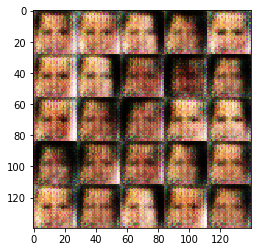

Epoch: 1/1; Batch:   425; Discriminator Loss: 0.8155... Generator Loss: 1.1943
Epoch: 1/1; Batch:   450; Discriminator Loss: 1.0936... Generator Loss: 2.5115
Epoch: 1/1; Batch:   475; Discriminator Loss: 0.7296... Generator Loss: 1.2042
Epoch: 1/1; Batch:   500; Discriminator Loss: 0.7930... Generator Loss: 1.9716
Epoch: 1/1; Batch:   525; Discriminator Loss: 0.8566... Generator Loss: 0.8360
Epoch: 1/1; Batch:   550; Discriminator Loss: 1.0716... Generator Loss: 1.6278
Epoch: 1/1; Batch:   575; Discriminator Loss: 0.8143... Generator Loss: 1.1007
Epoch: 1/1; Batch:   600; Discriminator Loss: 0.5980... Generator Loss: 1.9566


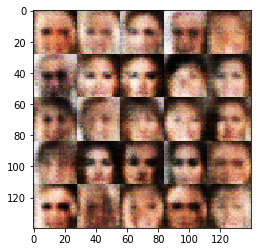

Epoch: 1/1; Batch:   625; Discriminator Loss: 1.1349... Generator Loss: 0.6050
Epoch: 1/1; Batch:   650; Discriminator Loss: 0.4520... Generator Loss: 2.0859
Epoch: 1/1; Batch:   675; Discriminator Loss: 1.1346... Generator Loss: 0.5446
Epoch: 1/1; Batch:   700; Discriminator Loss: 1.8438... Generator Loss: 0.2352
Epoch: 1/1; Batch:   725; Discriminator Loss: 0.6165... Generator Loss: 1.5311
Epoch: 1/1; Batch:   750; Discriminator Loss: 1.0783... Generator Loss: 0.6578
Epoch: 1/1; Batch:   775; Discriminator Loss: 0.8721... Generator Loss: 1.0858
Epoch: 1/1; Batch:   800; Discriminator Loss: 1.2006... Generator Loss: 0.5629


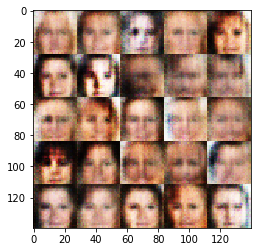

Epoch: 1/1; Batch:   825; Discriminator Loss: 1.0866... Generator Loss: 0.8986
Epoch: 1/1; Batch:   850; Discriminator Loss: 1.0814... Generator Loss: 1.3340
Epoch: 1/1; Batch:   875; Discriminator Loss: 1.2051... Generator Loss: 1.5850
Epoch: 1/1; Batch:   900; Discriminator Loss: 1.0366... Generator Loss: 1.0745
Epoch: 1/1; Batch:   925; Discriminator Loss: 0.8606... Generator Loss: 1.5338
Epoch: 1/1; Batch:   950; Discriminator Loss: 0.9223... Generator Loss: 0.8751
Epoch: 1/1; Batch:   975; Discriminator Loss: 1.1669... Generator Loss: 0.5588
Epoch: 1/1; Batch:  1000; Discriminator Loss: 1.0406... Generator Loss: 1.1799


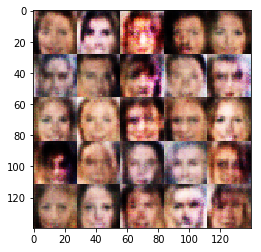

Epoch: 1/1; Batch:  1025; Discriminator Loss: 1.2337... Generator Loss: 0.5026
Epoch: 1/1; Batch:  1050; Discriminator Loss: 1.2750... Generator Loss: 0.4919
Epoch: 1/1; Batch:  1075; Discriminator Loss: 1.1186... Generator Loss: 1.7747
Epoch: 1/1; Batch:  1100; Discriminator Loss: 1.3319... Generator Loss: 2.1175
Epoch: 1/1; Batch:  1125; Discriminator Loss: 0.9743... Generator Loss: 0.7774
Epoch: 1/1; Batch:  1150; Discriminator Loss: 1.1807... Generator Loss: 1.0056
Epoch: 1/1; Batch:  1175; Discriminator Loss: 1.0841... Generator Loss: 0.6265
Epoch: 1/1; Batch:  1200; Discriminator Loss: 1.1039... Generator Loss: 1.6264


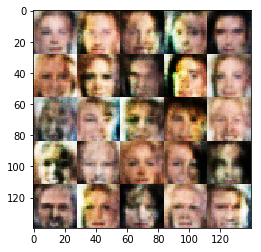

Epoch: 1/1; Batch:  1225; Discriminator Loss: 0.7994... Generator Loss: 1.3661
Epoch: 1/1; Batch:  1250; Discriminator Loss: 1.1268... Generator Loss: 0.5748
Epoch: 1/1; Batch:  1275; Discriminator Loss: 0.9155... Generator Loss: 1.2616
Epoch: 1/1; Batch:  1300; Discriminator Loss: 0.9240... Generator Loss: 1.1170
Epoch: 1/1; Batch:  1325; Discriminator Loss: 1.1405... Generator Loss: 0.6611
Epoch: 1/1; Batch:  1350; Discriminator Loss: 0.9227... Generator Loss: 1.0692
Epoch: 1/1; Batch:  1375; Discriminator Loss: 1.3871... Generator Loss: 0.3884
Epoch: 1/1; Batch:  1400; Discriminator Loss: 0.9991... Generator Loss: 0.7903


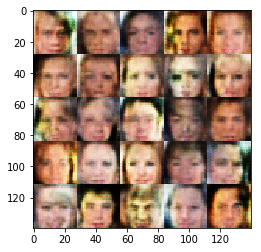

Epoch: 1/1; Batch:  1425; Discriminator Loss: 1.3137... Generator Loss: 1.2884
Epoch: 1/1; Batch:  1450; Discriminator Loss: 1.2143... Generator Loss: 0.5330
Epoch: 1/1; Batch:  1475; Discriminator Loss: 0.8133... Generator Loss: 1.0769
Epoch: 1/1; Batch:  1500; Discriminator Loss: 0.9919... Generator Loss: 1.1403
Epoch: 1/1; Batch:  1525; Discriminator Loss: 1.1191... Generator Loss: 0.7659
Epoch: 1/1; Batch:  1550; Discriminator Loss: 1.2352... Generator Loss: 0.5593
Epoch: 1/1; Batch:  1575; Discriminator Loss: 1.1737... Generator Loss: 0.7679
Epoch: 1/1; Batch:  1600; Discriminator Loss: 1.1162... Generator Loss: 1.5602


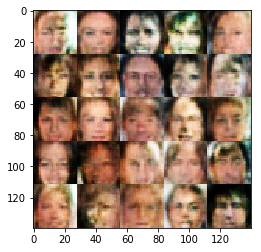

Epoch: 1/1; Batch:  1625; Discriminator Loss: 1.1586... Generator Loss: 0.5624
Epoch: 1/1; Batch:  1650; Discriminator Loss: 1.0802... Generator Loss: 0.7683
Epoch: 1/1; Batch:  1675; Discriminator Loss: 1.0943... Generator Loss: 1.3581
Epoch: 1/1; Batch:  1700; Discriminator Loss: 1.2349... Generator Loss: 1.4169
Epoch: 1/1; Batch:  1725; Discriminator Loss: 1.2054... Generator Loss: 1.3461
Epoch: 1/1; Batch:  1750; Discriminator Loss: 1.2374... Generator Loss: 0.5901
Epoch: 1/1; Batch:  1775; Discriminator Loss: 1.0771... Generator Loss: 0.6076
Epoch: 1/1; Batch:  1800; Discriminator Loss: 1.0008... Generator Loss: 0.8699


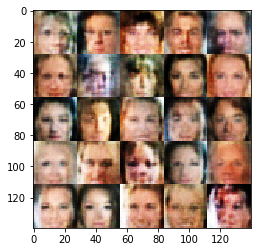

Epoch: 1/1; Batch:  1825; Discriminator Loss: 1.1255... Generator Loss: 0.7324
Epoch: 1/1; Batch:  1850; Discriminator Loss: 1.0856... Generator Loss: 0.6579
Epoch: 1/1; Batch:  1875; Discriminator Loss: 1.2951... Generator Loss: 0.4371
Epoch: 1/1; Batch:  1900; Discriminator Loss: 1.0853... Generator Loss: 0.6933
Epoch: 1/1; Batch:  1925; Discriminator Loss: 1.2388... Generator Loss: 0.5445
Epoch: 1/1; Batch:  1950; Discriminator Loss: 0.9838... Generator Loss: 1.4463
Epoch: 1/1; Batch:  1975; Discriminator Loss: 1.0464... Generator Loss: 0.6790
Epoch: 1/1; Batch:  2000; Discriminator Loss: 0.8453... Generator Loss: 1.5191


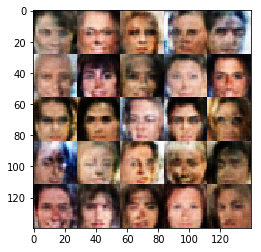

Epoch: 1/1; Batch:  2025; Discriminator Loss: 1.2185... Generator Loss: 0.5227
Epoch: 1/1; Batch:  2050; Discriminator Loss: 1.3564... Generator Loss: 0.4106
Epoch: 1/1; Batch:  2075; Discriminator Loss: 1.1034... Generator Loss: 1.2710
Epoch: 1/1; Batch:  2100; Discriminator Loss: 1.4309... Generator Loss: 0.3455
Epoch: 1/1; Batch:  2125; Discriminator Loss: 0.8776... Generator Loss: 1.1561
Epoch: 1/1; Batch:  2150; Discriminator Loss: 0.7328... Generator Loss: 1.7904
Epoch: 1/1; Batch:  2175; Discriminator Loss: 0.9124... Generator Loss: 0.9200
Epoch: 1/1; Batch:  2200; Discriminator Loss: 0.8717... Generator Loss: 1.1053


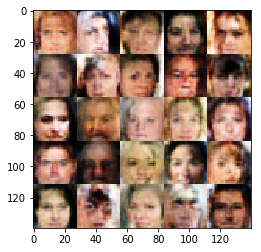

Epoch: 1/1; Batch:  2225; Discriminator Loss: 0.8630... Generator Loss: 1.3627
Epoch: 1/1; Batch:  2250; Discriminator Loss: 0.8580... Generator Loss: 1.0667
Epoch: 1/1; Batch:  2275; Discriminator Loss: 1.1652... Generator Loss: 1.2296
Epoch: 1/1; Batch:  2300; Discriminator Loss: 1.3606... Generator Loss: 0.4160
Epoch: 1/1; Batch:  2325; Discriminator Loss: 1.0733... Generator Loss: 0.6385
Epoch: 1/1; Batch:  2350; Discriminator Loss: 0.8110... Generator Loss: 1.0277
Epoch: 1/1; Batch:  2375; Discriminator Loss: 1.2011... Generator Loss: 0.5581
Epoch: 1/1; Batch:  2400; Discriminator Loss: 0.7369... Generator Loss: 2.1176


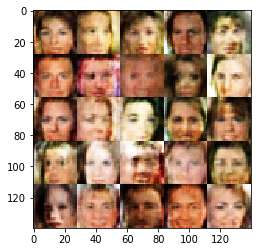

Epoch: 1/1; Batch:  2425; Discriminator Loss: 0.6751... Generator Loss: 1.1373
Epoch: 1/1; Batch:  2450; Discriminator Loss: 1.3250... Generator Loss: 0.4448
Epoch: 1/1; Batch:  2475; Discriminator Loss: 0.6593... Generator Loss: 2.1931
Epoch: 1/1; Batch:  2500; Discriminator Loss: 0.7105... Generator Loss: 1.0730
Epoch: 1/1; Batch:  2525; Discriminator Loss: 0.7249... Generator Loss: 1.3348
Epoch: 1/1; Batch:  2550; Discriminator Loss: 1.1152... Generator Loss: 0.5771
Epoch: 1/1; Batch:  2575; Discriminator Loss: 1.1072... Generator Loss: 0.5547
Epoch: 1/1; Batch:  2600; Discriminator Loss: 0.4996... Generator Loss: 1.8207


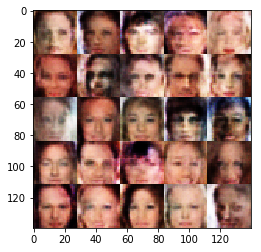

Epoch: 1/1; Batch:  2625; Discriminator Loss: 0.6074... Generator Loss: 1.4981
Epoch: 1/1; Batch:  2650; Discriminator Loss: 0.9707... Generator Loss: 1.3668
Epoch: 1/1; Batch:  2675; Discriminator Loss: 1.1789... Generator Loss: 1.8055
Epoch: 1/1; Batch:  2700; Discriminator Loss: 0.8709... Generator Loss: 1.8331
Epoch: 1/1; Batch:  2725; Discriminator Loss: 1.1402... Generator Loss: 2.7704
Epoch: 1/1; Batch:  2750; Discriminator Loss: 1.5920... Generator Loss: 0.2996
Epoch: 1/1; Batch:  2775; Discriminator Loss: 0.6135... Generator Loss: 2.3069
Epoch: 1/1; Batch:  2800; Discriminator Loss: 1.4721... Generator Loss: 0.3169


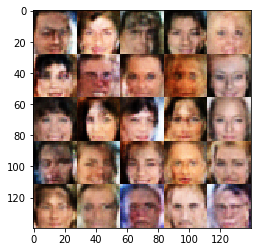

Epoch: 1/1; Batch:  2825; Discriminator Loss: 0.8608... Generator Loss: 1.7292
Epoch: 1/1; Batch:  2850; Discriminator Loss: 0.7740... Generator Loss: 1.1257
Epoch: 1/1; Batch:  2875; Discriminator Loss: 0.4871... Generator Loss: 1.2947
Epoch: 1/1; Batch:  2900; Discriminator Loss: 1.2509... Generator Loss: 1.5608
Epoch: 1/1; Batch:  2925; Discriminator Loss: 1.1497... Generator Loss: 0.5009
Epoch: 1/1; Batch:  2950; Discriminator Loss: 0.9801... Generator Loss: 0.6494
Epoch: 1/1; Batch:  2975; Discriminator Loss: 0.7777... Generator Loss: 1.1962
Epoch: 1/1; Batch:  3000; Discriminator Loss: 1.8994... Generator Loss: 0.2067


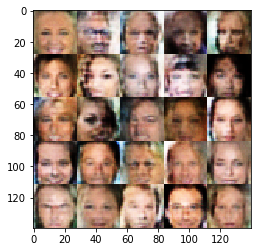

Epoch: 1/1; Batch:  3025; Discriminator Loss: 0.6428... Generator Loss: 1.5440
Epoch: 1/1; Batch:  3050; Discriminator Loss: 1.2435... Generator Loss: 1.7976
Epoch: 1/1; Batch:  3075; Discriminator Loss: 0.6715... Generator Loss: 2.7716
Epoch: 1/1; Batch:  3100; Discriminator Loss: 0.9865... Generator Loss: 0.5788
Epoch: 1/1; Batch:  3125; Discriminator Loss: 0.9245... Generator Loss: 0.8501
Epoch: 1/1; Batch:  3150; Discriminator Loss: 0.7719... Generator Loss: 1.1179


In [34]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.